# Looking at equity data

In [8]:
import os
import git
import sys

git_repo = git.Repo(os.getcwd(), search_parent_directories=True)
git_root = git_repo.git.rev_parse("--show-toplevel")

sys.path.append(git_root)

import numpy as np
import random
from abm_vec.calibration import get_calibration_variables
from abm_vec.initialization import generate_random_entities, get_bank_data
import matplotlib.pyplot as plt
import seaborn as sns
from abm_vec.essentials import get_git_root_directory
from scipy.stats import multivariate_normal, norm

In [9]:
calibration_variables = get_calibration_variables()

In [10]:
bank_data = get_bank_data()
bank_equity = bank_data["equity"]
bank_deposits = bank_data["deposits"]
bank_loans = bank_data["loans"]
(
    firm_equity,
    firm_prod,
    firm_ex_supply,
    firm_wage,
    firm_pd,
    firm_supply,
    firm_profit,
    firm_price,
    firm_max_leverage,
) = generate_random_entities(calibration_variables)

# Bounded Pareto

In [11]:
def truncated_pareto_inv(y, alpha, lb, ub):
    return (- (y * ub ** alpha - y * lb ** alpha - ub ** alpha) / (lb ** alpha * ub ** alpha)) ** (-1/alpha)

def boundedParetoNormal(size, lb1, lb2, ub1, ub2, alpha1, alpha2, rho):
    marginal_distribution = multivariate_normal(mean=[0, 0], cov=[[1, rho], [rho, 1]])
    random_samples_marginal = marginal_distribution.rvs(size=size)
    copula_samples = norm.cdf(random_samples_marginal)
    x1 = truncated_pareto_inv(copula_samples[:, 0], alpha1, lb1, ub1)
    x2 = truncated_pareto_inv(copula_samples[:, 1], alpha2, lb2, ub2)
    return x1, x2

In [12]:
x1, x2 = boundedParetoNormal(10000, lb1=10**6, lb2=3500, ub1=15 * 10**7, ub2=1.5 * 10 ** 6, alpha1=1.6, alpha2=1.6, rho=0.5)

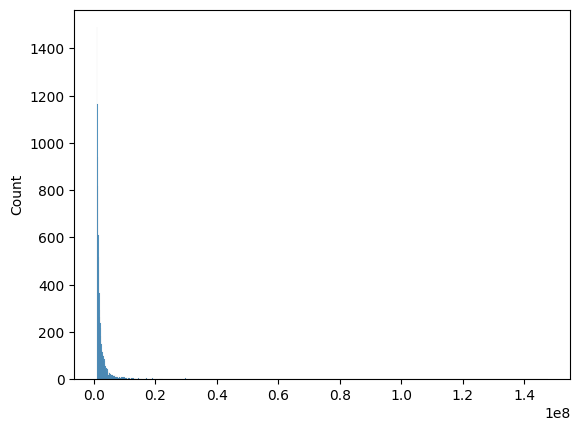

In [13]:
sns.histplot(x1)
plt.show()

In [14]:
quantile_99 = np.quantile(x1, 0.99)
print(round(quantile_99/ 10**6,2)) 

18.41


# Total Loans in the system

In [15]:
sum(bank_loans) / 10 **6

239119.7878

In [16]:
sum(firm_max_leverage * x1) / 10 ** 6

220563.0143138594

In [17]:
(sum(bank_loans) / 10 **6 - sum(firm_max_leverage * x1) / 10 ** 6) / (sum(bank_loans) / 10 **6)

0.07760450800358477

#### Now to find optimal supply level

In [18]:
upper_bound_supply = firm_prod * (1 + firm_max_leverage) * x1 / firm_wage

<Axes: ylabel='Count'>

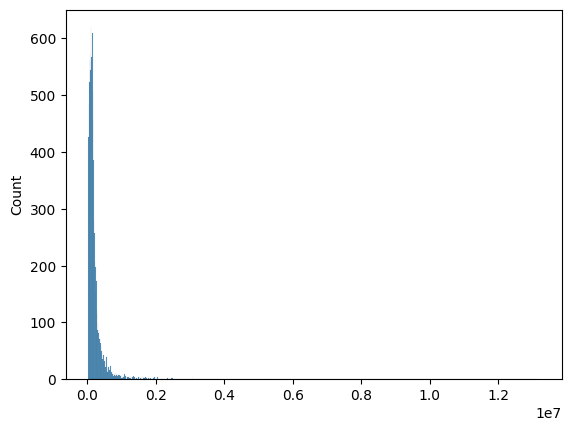

In [19]:
sns.histplot(upper_bound_supply)

In [20]:
min(upper_bound_supply)

28587.05323822243

In [21]:
max(upper_bound_supply) / 10 **6

13.191860284206369

In [22]:
len([x for x,y in zip(x2, upper_bound_supply) if x> y])

7

In [23]:
# try to see optimal min price
firm_total_wage = firm_wage * x2 / firm_prod
p_min = (firm_total_wage + calibration_variables['policy_rate'] * np.maximum(firm_total_wage - x1, 0)) / x2

<Axes: ylabel='Count'>

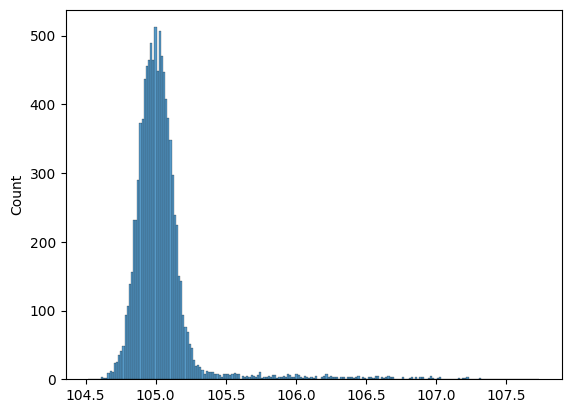

In [24]:
sns.histplot(p_min)

In [25]:
p = (1 + calibration_variables['policy_rate']) * calibration_variables['min_wage'] / calibration_variables['min_productivity']

In [26]:
p

102.5

# Trying to calibrate the model

In [27]:
 from abm_vec.calibration import get_calibration_variables
from abm_vec.initialization import generate_random_entities
from abm_vec.essentials import wages_adj, compute_expected_supply_price
from abm_vec.firms import (
    check_loan_desire_and_choose_loans,
    get_non_zero_values_from_matrix,
    shuffle_firms,
)
from abm_vec.banks import asses_loan_requests_firms
from abm_vec.create_network_connections import create_network_connections
from abm_vec.clear_firm_default import clear_firm_default
from abm_vec.clear_interbank_market import clear_interbank_market
from scipy.stats import kstest

In [28]:
def variables_gen(x):
    seed_value = 0
    random.seed(seed_value)
    np.random.seed(seed_value)
    use_bank_weights = True
    # get calibration variables for initialization and markov model
    calibration_variables = get_calibration_variables()
    calibration_variables['firm_lb1'] = x[0]
    calibration_variables['firm_lb2'] = x[1]
    calibration_variables['firm_ub1'] = x[2]
    calibration_variables['firm_ub2'] = x[3]
    calibration_variables['firm_alpha1'] = x[4]
    calibration_variables['firm_alpha2'] = x[5]
    calibration_variables['firm_rho'] = x[6]
    calibration_variables['min_productivity'] = x[7]
    calibration_variables['market_price'] = x[8]

    bank_data = get_bank_data()
    bank_equity = bank_data["equity"]
    bank_deposits = bank_data["deposits"]
    bank_loans = bank_data["loans"]

    (
        firm_equity,
        firm_prod,
        firm_ex_supply,
        firm_wage,
        firm_pd,
        firm_supply,
        firm_profit,
        firm_price,
        firm_max_leverage,
    ) = generate_random_entities(calibration_variables)
    
    
    num_firms = len(firm_price)
    num_banks = len(bank_loans)
    
    if use_bank_weights:
        bank_weights = bank_loans / sum(bank_loans)
    else:
        bank_weights = np.array([1/num_banks] * num_banks)

    t=0

    # store prior period equity
    prior_period_equity = bank_equity.copy()
    # shuffle firms
    (
        firm_equity,
        firm_prod,
        firm_ex_supply,
        firm_wage,
        firm_pd,
        firm_supply,
        firm_profit,
        firm_price,
        firm_max_leverage,
    ) = shuffle_firms(
        num_firms,
        firm_equity,
        firm_prod,
        firm_ex_supply,
        firm_wage,
        firm_pd,
        firm_supply,
        firm_profit,
        firm_price,
        firm_max_leverage,
    )

    # for each firm compute expected supply and see who wants loans
    firm_wage = wages_adj(firm_wage, calibration_variables["min_wage"])
    firm_price, firm_supply, firm_total_wage, supply_threshold_breach = compute_expected_supply_price(
        firm_ex_supply,
        firm_supply,
        firm_price,
        calibration_variables["market_price"],
        firm_wage,
        firm_prod,
        calibration_variables["firm_init_excess_supply_prob"],
        firm_profit,
        firm_max_leverage,
        firm_equity,
    )

    firm_credit_demand = np.maximum(0, firm_total_wage - firm_equity)
    firm_financial_fragility = firm_credit_demand / firm_equity
    loan_indicator = check_loan_desire_and_choose_loans(
        firm_credit_demand, num_firms, num_banks, calibration_variables["max_bank_loan"], bank_weights
    )

    # let bank give interest rates
    bank_current_deposit = bank_deposits.copy()
    bank_max_credit = bank_deposits / calibration_variables["capital_req"]
    firm_interest = asses_loan_requests_firms(
        loan_indicator,
        firm_credit_demand,
        bank_max_credit,
        firm_pd,
        firm_financial_fragility,
        calibration_variables["policy_rate"],
        calibration_variables["h_theta"],
    )

    # get loans by firm
    loans_by_firm = get_non_zero_values_from_matrix(firm_interest)

    (loan_firms_interest,
     loan_firms_amount,
     loan_banks_interest,
     loan_banks_amount,
     cds_amount,
     cds_spread,
     cds_spread_amount,
     bank_current_deposit,
     firm_equity,
     cds_dict,
     bank_loan_asset
     ) = create_network_connections(loans_by_firm,
                                    calibration_variables,
                                    num_firms,
                                    num_banks,
                                    firm_credit_demand,
                                    bank_max_credit,
                                    bank_deposits,
                                    bank_current_deposit,
                                    firm_equity,
                                    firm_pd,
                                    bank_equity)

    new_price = np.average(firm_price)
    empirical_le_ratio = bank_loans / bank_equity
    simulated_le_ratio = bank_loan_asset / bank_equity
    return empirical_le_ratio, simulated_le_ratio, new_price, supply_threshold_breach, calibration_variables['market_price']

In [29]:
x = [10**6, 7500, 15 * 10 ** 7, 0.7 * 10 ** 6, 1.6, 1.7, 0.9, 150, 820]

In [30]:
empirical_le_ratio, simulated_le_ratio, new_price, supply_threshold_breach, market_price = variables_gen(x)

<Axes: ylabel='Count'>

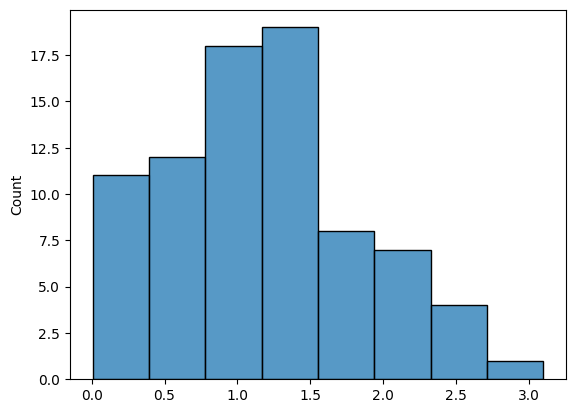

In [31]:
sns.histplot(empirical_le_ratio)

<Axes: ylabel='Count'>

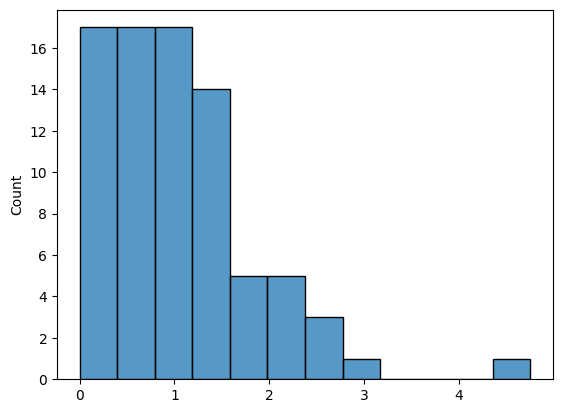

In [32]:
sns.histplot(simulated_le_ratio)

In [33]:
kstest(empirical_le_ratio, simulated_le_ratio, alternative='two-sided').pvalue

0.12022067556844308

In [34]:
supply_threshold_breach

1259

In [35]:
(new_price - market_price) / market_price

0.09544172505903942

# Try to optimize calibration

In [36]:
from scipy.optimize import differential_evolution
from scipy.optimize import minimize

In [37]:
def calibration_optimize(x):
    empirical_le_ratio, simulated_le_ratio, new_price, supply_threshold_breach, market_price = variables_gen(x)
    pvalue = kstest(empirical_le_ratio, simulated_le_ratio, alternative='two-sided').pvalue
    return -pvalue

In [38]:
bounds = [(5 * 10 ** 5, 5 * 10** 6), (10 ** 3, 10**4), (5 * 10** 7, 30 * 10 ** 7), (5 * 10 ** 5, 10 ** 7), (0, 3), (0, 3), (0, 1) , (100, 1000), (50, 2000)]
initial_guess = [10**6, 7500, 15 * 10 ** 7, 0.7 * 10 ** 6, 1.6, 1.7, 0.9, 150, 820]

In [39]:
result = minimize(calibration_optimize, initial_guess, method='Nelder-Mead', bounds=bounds)

In [40]:
vals = result.x

In [45]:
%%time
empirical_le_ratio, simulated_le_ratio, new_price, supply_threshold_breach, market_price = variables_gen(vals)

CPU times: user 2.45 s, sys: 148 ms, total: 2.6 s
Wall time: 2.59 s


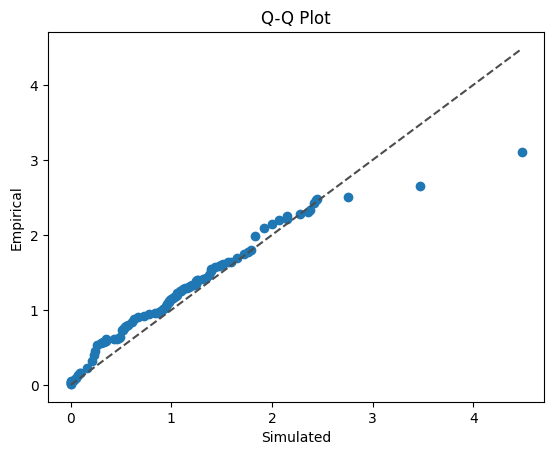

In [42]:
quantiles1 = np.percentile(simulated_le_ratio, np.linspace(0, 100, 100))
quantiles2 = np.percentile(empirical_le_ratio, np.linspace(0, 100, 100))

plt.scatter(quantiles1, quantiles2)
plt.xlabel('Simulated')
plt.ylabel('Empirical')
plt.title('Q-Q Plot')
plt.plot([quantiles1.min(), quantiles1.max()], [quantiles1.min(), quantiles1.max()], ls="--", c=".3")
plt.show()

In [43]:
pvalue = kstest(empirical_le_ratio, simulated_le_ratio, alternative='two-sided').pvalue

In [44]:
pvalue

0.4382622708472999